In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import sys


data=pd.read_csv('../data/cancer/data.csv')

In [2]:
y = data['diagnosis']

del data['diagnosis']
#Select only specific columns
interesting_cols = ['texture_mean','area_mean','smoothness_mean','concavity_mean','area_se','concavity_se','smoothness_worst','concavity_worst','symmetry_worst']

X = data[interesting_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

#Create necessary csv-files. Do this only on first execution
# X_test.to_csv("../data/cancer/X_test.csv", header = False, index=False)
# X_train.to_csv("../data/cancer/X_train.csv", header = False, index=False)
# X_val.to_csv("../data/cancer/X_val.csv", header = False, index=False)
# y_train.to_csv("../data/cancer/y_train.csv", index=False)
# y_test.to_csv("../data/cancer/y_test.csv", index=False)
# y_val.to_csv("../data/cancer/y_val.csv", index=False)

X.describe()

,texture_mean,area_mean,smoothness_mean,concavity_mean,area_se,concavity_se,smoothness_worst,concavity_worst,symmetry_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,19.289649,654.889104,0.096360,0.088799,40.337079,0.031894,0.132369,0.272188,0.290076
std,4.301036,351.914129,0.014064,0.079720,45.491006,0.030186,0.022832,0.208624,0.061867
min,9.710000,143.500000,0.052630,0.000000,6.802000,0.000000,0.071170,0.000000,0.156500
25%,16.170000,420.300000,0.086370,0.029560,17.850000,0.015090,0.116600,0.114500,0.250400
50%,18.840000,551.100000,0.095870,0.061540,24.530000,0.025890,0.131300,0.226700,0.282200
75%,21.800000,782.700000,0.105300,0.130700,45.190000,0.042050,0.146000,0.382900,0.317900
max,39.280000,2501.000000,0.163400,0.426800,542.200000,0.396000,0.222600,1.252000,0.663800


In [3]:
clf = tree.DecisionTreeClassifier(random_state=4)

# simple Decision Tree without optimization

clf.fit(X_train_val, y_train_val)
dtPredictionsTrain = clf.predict(X_train_val)
dtPredictionsTest = clf.predict(X_test)

print("Simple Dec Tree accuracy on the training set:", accuracy_score(y_train_val, dtPredictionsTrain))
print("Simple Dec Tree accuracy on the test set:", accuracy_score(y_test, dtPredictionsTest))

print(pd.DataFrame(
    confusion_matrix(y_test, dtPredictionsTest),
    columns=['Predicted No cancer', 'Predicted cancer'],
    index=['No cancer', 'cancer']
))


tn, fp, fn, tp = confusion_matrix(y_test, dtPredictionsTest).ravel()
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)
print("\nSimple\n")
print("Sensitivität: ", sensitivity)
print("Spezifität: ", specificity)
print("Parameter des simplen Decision Trees: ", clf.get_params())


Simple Dec Tree accuracy on the training set: 1.0
Simple Dec Tree accuracy on the test set: 0.8859649122807017
           Predicted No cancer  Predicted cancer
No cancer                   67                 5
cancer                       8                34

Simple

Sensitivity:  0.8095238095238095
Spezifität:  0.9305555555555556
Parameter of simple decision Tree:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 4, 'splitter': 'best'}


In [4]:
#New approach using RandomizedSearchCV

criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
max_features = [int(x) for x in np.linspace(start = 1, stop = 9, num = 9)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 100, num = 99)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
random_state = [int(x) for x in np.linspace(start = 0, stop = 10000, num = 3000)]

random_grid = {'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'random_state': random_state}

dt = tree.DecisionTreeClassifier()
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, n_iter = 5000, cv = 2, verbose=2, random_state=42, n_jobs = -1)
dt_random.fit(X_train_val, y_train_val)

print(dt_random.best_params_)

base_model = clf

base_accuracy = accuracy_score(y_test, dtPredictionsTest)
print("base_accuracy: ",base_accuracy)
best_random = dt_random.best_estimator_
dt_randomPredictionsTest = dt_random.predict(X_test)
random_accuracy = accuracy_score(y_test, dt_randomPredictionsTest)
print("random_accuracy: ",random_accuracy)

print('Verbesserung um {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))



Fitting 2 folds for each of 5000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 2724 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 7190 tasks      | elapsed:   15.2s


{'random_state': 3621, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 18, 'criterion': 'gini'}
base_accuracy:  0.8859649122807017
random_accuracy:  0.9035087719298246
Improvement of 1.98%.


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   20.0s finished
/home/Uni/blaucloud/Informatik/Arbeit/ml/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [5]:
print("Random")
print(pd.DataFrame(
    confusion_matrix(y_test, dt_randomPredictionsTest),
    columns=['Predicted No cancer', 'Predicted cancer'],
    index=['No cancer', 'cancer']
))

tn, fp, fn, tp = confusion_matrix(y_test, dt_randomPredictionsTest).ravel()
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)

print("sensitivity", sensitivity)
print("Specificity", specificity)

Random
           Predicted No cancer  Predicted cancer
No cancer                   71                 1
cancer                      10                32
sensitivity 0.7619047619047619
Specificity 0.9861111111111112


In [6]:
# Random Forest
rf = ensemble.RandomForestClassifier(random_state=7)
rf.fit(X_train_val, y_train_val)

rfPredictionsTrain = rf.predict(X_train_val)

rfPredictionsTest = rf.predict(X_test)


print("Random Forest accuracy on the training set:", accuracy_score(y_train_val, rfPredictionsTrain))

print("Random Forest accuracy on the test set:", accuracy_score(y_test, rfPredictionsTest))

#Sensitivity and Specificity

print("Random Forest")
print(pd.DataFrame(
    confusion_matrix(y_test, rfPredictionsTest),
    columns=['Predicted No cancer', 'Predicted cancer'],
    index=['No cancer', 'cancer']
))

tn, fp, fn, tp = confusion_matrix(y_test, rfPredictionsTest).ravel()
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)

print("sensitivity", sensitivity)
print("Specificity", specificity)

Random Forest accuracy on the training set: 0.9956043956043956
Random Forest accuracy on the test set: 0.9298245614035088
Random Forest
           Predicted No cancer  Predicted cancer
No cancer                   69                 3
cancer                       5                37
sensitivity 0.8809523809523809
Specificity 0.9583333333333334


/home/Uni/blaucloud/Informatik/Arbeit/ml/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/home/franz/miniconda3/envs/mainenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest optimized for recall
[0.82142857 0.96428571 0.92592593 0.92592593 0.81481481]
Random Forest optimised accuracy on the training set: 0.9945054945054945
Random Forest optimised accuracy on the test set: 0.9473684210526315


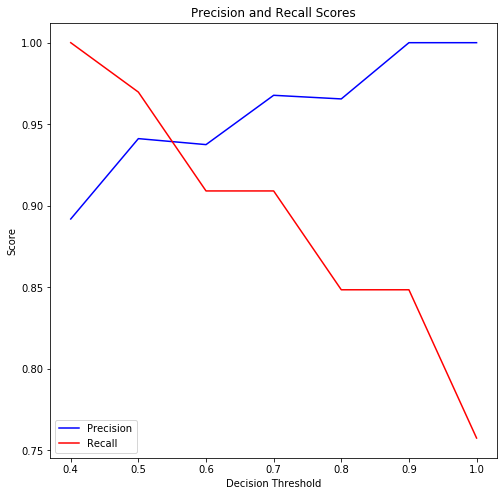

In [7]:
#Random Forest optimized for high sensitivity/recall
rf_opt = ensemble.RandomForestClassifier(n_jobs=-1, random_state=42)


rf_opt.fit(X_train, y_train)
y_scores = rf_opt.predict_proba(X_train)[:,1]
p, r, thresholds = precision_recall_curve(y_train, y_scores)

print("Random Forest optimized for recall")
print(cross_val_score(rf_opt, X_train, y_train, scoring='recall', cv=5))
    
    
def plot_precision_recall_vs_threshold(p, r, thresholds):
    """
    Plots the precision-recall-graph for different thresholds. 
    Uses output of precision_recall_curve function in scikit-learn
    
    Parameters
    ----------
    p : numpy.ndarray
        The list of all precision values
    r : numpy.ndarray
        The list of all recall values
    thresholds : numpy.ndarray
        The list of all thresholds
    """
    
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores")
    plt.plot(thresholds, p[:-1], "b-", label="Precision")
    plt.plot(thresholds, r[:-1], "r-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

threshold = 0.4

y_scores = rf_opt.predict_proba(X_val)[:,1]
p, r, thresholds = precision_recall_curve(y_val, y_scores)
plot_precision_recall_vs_threshold(p, r, thresholds)


predicted_probaTrain = rf_opt.predict_proba(X_train)
rf_optPredictionsTrain = (predicted_probaTrain [:,1] >= threshold).astype('int')

predicted_probaTest = rf_opt.predict_proba(X_test)
rf_optPredictionsTest = (predicted_probaTest [:,1] >= threshold).astype('int')


print("Random Forest optimised accuracy on the training set:", accuracy_score(y_train, rf_optPredictionsTrain))

print("Random Forest optimised accuracy on the test set:", accuracy_score(y_test, rf_optPredictionsTest))


K Nearest Neighbors accuracy on the training set: 0.8989010989010989
K Nearest Neighbors accuracy on the test set: 0.8859649122807017


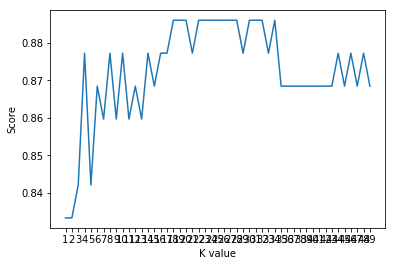

Maximum KNN Score is 88.60% at
[18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34]
           Predicted No cancer  Predicted cancer
No cancer                   72                 0
cancer                      13                29
sensitivity 0.6904761904761905
Specificity 1.0


In [8]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(X_train_val, y_train_val)

knnPredictionsTrain = knn.predict(X_train_val)

knnPredictionsTest = knn.predict(X_test)


print("K Nearest Neighbors accuracy on the training set:", accuracy_score(y_train_val, knnPredictionsTrain))

print("K Nearest Neighbors accuracy on the test set:", accuracy_score(y_test, knnPredictionsTest))

scoreList = []
#Find best amount of neighbors
for i in range(1,50):
    knn2 = KNeighborsClassifier(n_neighbors = i)  
    knn2.fit(X_train_val, y_train_val)
    scoreList.append(knn2.score(X_test, y_test))
    
plt.plot(range(1,50), scoreList)
plt.xticks(np.arange(1,50,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

m = max(scoreList)
[i for i, j in enumerate(scoreList) if j == m]

print("Maximum KNN Score is {:.2f}% at".format(m*100))
print([i+1 for i, j in enumerate(scoreList) if j == m])

#Sensitivity and Specificity
print(pd.DataFrame(
    confusion_matrix(y_test, knnPredictionsTest),
    columns=['Predicted No cancer', 'Predicted cancer'],
    index=['No cancer', 'cancer']
))
tn, fp, fn, tp = confusion_matrix(y_test, knnPredictionsTest).ravel()
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)

print("sensitivity", sensitivity)
print("Specificity", specificity)


In [11]:
import joblib
dtmodel_random = open("models/dtmodel_random.pkl","wb")
joblib.dump(dt_random,dtmodel_random)
dtmodel_random.close

dtModel_simple = open("models/dtmodel_simple.pkl", "wb")
joblib.dump(clf, dtModel_simple)
dtModel_simple.close

knn_model = open("models/knn_model.pkl", "wb")
joblib.dump(knn, knn_model)
knn_model.close

rf_model = open("models/rf_model.pkl", "wb")
joblib.dump(rf, rf_model)
rf_model.close

rf_opt_model = open("models/rf_opt_model.pkl", "wb")
joblib.dump(rf_opt, rf_opt_model)
rf_opt_model = open("models/rf_opt_model.pkl", "rb")
joblib.load(rf_opt_model)
rf_opt_model.close

<function BufferedReader.close>